In [1]:
%run Futures.ipynb

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import os, glob
import statistics

In [3]:
work_dir = os.getcwd()
work_dir

'C:\\Users\\Evan\\Documents\\GitHub\\TXO_TX_Strategy'

In [4]:
extension = 'csv'
Future_path = os.path.join(work_dir, 'Data', 'Futures')
os.chdir(Future_path)
Fut_csv_List = glob.glob('*.{}'.format(extension))


In [5]:
Data_path = os.path.join(work_dir, 'Data', 'TX00')
TX = pd.read_csv(os.path.join(Data_path, 'TX_0424.csv'), encoding = 'cp950')
TX['日期'] = pd.to_datetime(TX['日期']) 

In [6]:
TX00 = TX.drop_duplicates(subset = ['日期'], keep = 'first').reset_index(drop=True)

In [7]:
TX00.tail()

,期貨名稱,日期,到期月,開盤價,收盤價,每日結算價,未平倉合約數,無風險利率
24,TX202005 台指 2020/05,2020-04-20,20-May,10538.0,10525.0,10475,76238,0.795
25,TX202005 台指 2020/05,2020-04-21,20-May,10476.0,10395.0,10196,84193,0.795
26,TX202005 台指 2020/05,2020-04-22,20-May,10231.0,10129.0,10222,81780,0.795
27,TX202005 台指 2020/05,2020-04-23,20-May,10240.0,10277.0,10292,80199,0.795
28,TX202005 台指 2020/05,2020-04-24,20-May,10308.0,10288.0,10268,80100,0.795


In [8]:
List5min = []
for dataCsv in Fut_csv_List: 
    Fut = Futures(dataCsv)
    List5min.append(Fut.get_TransPrice(tTime = 85000))

In [13]:
TX00['CC'] = TX00['每日結算價'].pct_change()
TX00['OC'] = (TX00['收盤價'] - TX00['開盤價'])/TX00['開盤價']
TX00['SP'] = List5min 
TX00['SC'] = (TX00['收盤價'] - TX00['SP'])/TX00['SP']

In [14]:
TX00.head()

,期貨名稱,日期,到期月,開盤價,收盤價,每日結算價,未平倉合約數,無風險利率,CC,OC,SC,SP
0,TX202003 台指 2020/03,2020-03-13,20-Mar,10362.0,9822.0,10027,94984,1.0,NaN,-0.052113,0.006672,9756.90
1,TX202003 台指 2020/03,2020-03-16,20-Mar,10030.0,10185.0,9679,70351,1.0,-0.034706,0.015454,0.027110,9916.17
2,TX202003 台指 2020/03,2020-03-17,20-Mar,9623.0,9215.0,9371,52372,1.0,-0.031821,-0.042398,-0.012686,9333.40
3,TX202003 台指 2020/03,2020-03-18,20-Mar,9396.0,9470.0,9264,40267,1.0,-0.011418,0.007876,0.018937,9294.00
4,TX202004 台指 2020/04,2020-03-19,20-Apr,8788.0,8728.0,8356,104495,1.0,-0.098014,-0.006827,-0.012323,8836.90


In [37]:
date = TX00.日期.unique()

# Description of the Performance

In [28]:
def get_HPR(pnl):
    days = len(pnl)
    years = days/252
    HPR = pnl[days-1]/100 - 1 
    return HPR

In [29]:
def get_APR(pnl): 
    days = len(pnl)
    years = days/252
    HPR = get_HPR(pnl)
    APR = (HPR + 1)**(1/years) - 1 # annulized the cumulative returns
    return APR

In [30]:
def get_Sharp(pnl, rf): 
    Std = pnl.pct_change().std() # the standard deviation of the return 
    AStd = Std * np.sqrt(252) # annulized the std
    APR = get_APR(pnl)
    SharpRatio = round((APR - rf) / AStd, 4)
    return SharpRatio

In [31]:
def get_mdd(pnl):
    dd = pnl - pnl.cummax()
    dd_pct = dd/pnl.cummax()
    mdd = round(dd_pct.min(), 4)
    return mdd

In [32]:
def print_performance(pnl, rf = 0.01045):
    HPR = get_HPR(pnl) # the cumulative returns
    APR = get_APR(pnl) # annulized the cumulative returns
    SharpRatio = get_Sharp(pnl, rf)
    mdd = get_mdd(pnl)
    
    print("HPR: " + str(HPR)) 
    print("APR: " + str(APR)) 
    print("Sharp Ratio: " + str(SharpRatio))   
    print("mdd: " + str(mdd))

In [52]:
def plot_performance(pnl, date, title_name):
    
    dd = pnl - pnl.cummax()
    dd_pct = dd/pnl.cummax()
    mdd = get_mdd(pnl)
    HPR = get_HPR(pnl)
    APR = get_APR(pnl)
    
    
    plt.style.use('ggplot')
    plt.figure(figsize=(10,5))
    plt.grid()
    plt.subplot(211)
    plt.plot(date, pnl, color = 'Red')
    plt.title(title_name)
    plt.xlabel('Days', fontsize=14)
    plt.ylabel('Price', fontsize=14)
    
    textstr = '\n'.join((
            r'HPR = %.4f' % (HPR, ),
            r'APR = %.4f' % (APR, ), 
            r'MDD = %.4f' % (mdd, )))

    plt.text(date[0], pnl.max()*0.99, textstr, fontsize=10,
    verticalalignment='top', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))    
    
    

    plt.subplot(212)
    plt.bar(date, dd_pct, color = 'blue')
    plt.xlabel('Days', fontsize=14)
    plt.ylabel('Drawdown', fontsize=14)

    plt.savefig(os.path.join(work_dir, 'Graph', title_name))
    plt.show()

# Strategy 1

In [34]:
def buyandhold(data): 
    length = len(data)
    idx = [True] * length 
    
    data['LS'] = idx
    data['pnl'] = 100 * (1 + data['LS'] * data['CC']).cumprod()
    
    return data['pnl']

In [50]:
pnl = buyandhold(TX00)
pnl.update(pd.Series([100], index=[0]))

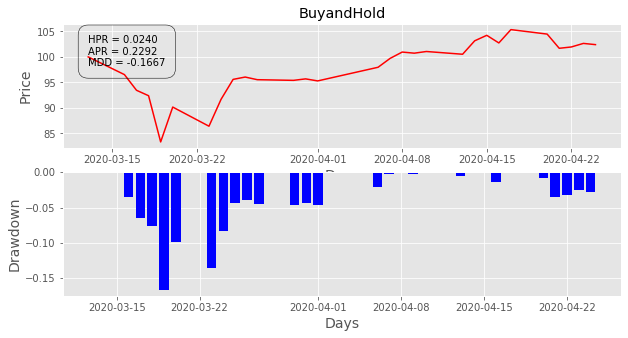

In [53]:
plot_performance(pnl, date = date, title_name = 'BuyandHold')

# Strategy 2

In [15]:
def strategy2_LS(data, CPIVchange): 
    # Buy if the CPIV change is positive, Sell if the CPIV change is negative
    length = len(data)
    idx = [0] * length
    for i in range(0, len(CPIVchange)):
        if CPIVchange[i] > 0: 
            idx[i] = 1
        elif CPIVchange[i] < 0: 
            idx[i] = -1
        else: 
            idx[i] = 0

    data['LS'] = idx
    data['pnl'] = 100 * (1 + data['LS'].shift(1) * data['SC']).cumprod()
    
    return data['pnl']